<a href="https://colab.research.google.com/github/rubyvanrooyen/HartRAO_OH-IR_stars/blob/master/Visualising_HartRAO_OH_monitoring_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inputs and downloads

In [1]:
#@title Backend scripts and data file from GitHub 
!git clone 'https://github.com/rubyvanrooyen/HartRAO_OH-IR_stars.git'
!ln -s HartRAO_OH-IR_stars/hart_io.py

fatal: destination path 'HartRAO_OH-IR_stars' already exists and is not an empty directory.
ln: failed to create symbolic link './hart_io.py': File exists


Input parameters required:
* Name of source for section of HartRAO data file
* Julian date format for timestamp conversion
* Observation epoch

In [37]:
#@title User select input and parameters to read and interpret file

sources = "VMic" #@param ["IKTau", "VMic", "OH357.3"]
tsformat = 'mjd' #@param ["mjd", "jd"]
epoch = 0. #@param {type:"number"}

print(f"Reading '{sources}' OH monitoring file")
print(f"Assuming epoch {epoch} and "
      f"'{tsformat}' format for time interpretation")

Reading 'VMic' OH monitoring file
Assuming epoch 0.0 and 'mjd' format for time interpretation


# Data input

Expected input format is comma separated data columns containing timeseries of spectra over velocity per channel

In [38]:
import requests
import io
print(sources.lower())
if 'vmic' in sources.lower():
    url='https://raw.githubusercontent.com/rubyvanrooyen/HartRAO_OH-IR_stars/master/data/vmic/vmic.tscatJD'
if 'iktau' in sources.lower():
    url='https://raw.githubusercontent.com/rubyvanrooyen/HartRAO_OH-IR_stars/master/data/iktau/iktausMWch.tscat'
res = requests.get(url)
f = io.StringIO(res.text)

vmic


OH monitoring data files are comma spearated (CSV) ASCII files tabulating the observed data.
The files have the following structure: 
* Line 0: a human readable string for information
* Line 1: a header line containing the timestamps followed by the channel velocities per column
* Line 2-N: timeseries data with a timestamp in the format indicated by the header in the first column, followed by the per channel spectra value

Layout of data per row:
* First column is timestamps in DJ - epoch
* Remaining columns are spectral channels

In [39]:
import hart_io as io
# read input data assuming HartRAO format
[header,
 chan_vel,
 timestamps,
 spectra,
 ts_jd] = io.input(file_obj=f,
                   epoch=epoch,
                   tsformat=tsformat)
avg_spectra = spectra.mean(axis=0)  

In [40]:
# human readable string for information
# timestamps [channel velocities]
print(header)
print('Spectral data size (#ts, #ch) = ({}, {})'.format(timestamps.size, spectra.shape[1]))
[comment, head_line] = header.strip().split('\n')

VMIC         OH1612 time series of intensities F from vmic.sf85
MJD,              -5.467,      -5.002,      -4.537,      -4.072,      -3.607,      -3.142,      -2.677,      -2.212,      -1.748,       4.296,       4.761,       5.226,       5.690,       6.155,       6.620,       7.085,       7.550,       8.015,

Spectral data size (#ts, #ch) = (157, 18)


# Data visualisation

Assuming the double-peaked profile of the velocity spectrum for the OH masers, identify the brightest blue- and red-shifted peaks representing the radiation arising from the near- and far-sides of the dust shell along the line of sight.

From the spectrum averaged over time for all channels, identify the maximum strength blue shifted and red shifted channels.
If the identified channels are located on a flat peak, 2 or 3 consecutive channels are average for robustness.




In [55]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

from ipywidgets import interact, widgets

In [42]:
# average over a couple of channels around peak if flat max
def peak_channels(spectrum, channel, threshold=0.9):
    channels = np.array([channel])
    if (spectrum[channel-1]/spectrum[channel]) > threshold:
        channels = np.hstack([channel-1, channels])
    if (spectrum[channel+1]/spectrum[channel]) > threshold:
        channels = np.hstack([channels, channel+1])
    return channels

def guess_channels(avg_spectra, chan_vel):
    cen_channel = len(chan_vel)//2
    max_blue_idx = np.argmax(avg_spectra[:cen_channel])
    blue_ch_idx = peak_channels(avg_spectra,
                                channel=max_blue_idx)
    max_red_idx = cen_channel + np.argmax(avg_spectra[cen_channel:])
    red_ch_idx = peak_channels(avg_spectra,
                               channel=max_red_idx)
    return max_blue_idx, blue_ch_idx, max_red_idx, red_ch_idx

In [43]:
def plot_spectra(chan_vel, avg_spectra, blue_ch_idx, red_ch_idx, fig_name=None):
    if len(blue_ch_idx)%2 > 0:
        max_blue_ch = blue_ch_idx[len(blue_ch_idx)//2] + 1
    else:
        max_blue_ch = blue_ch_idx[np.argmax(avg_spectra[blue_ch_idx])] + 1
    if len(red_ch_idx)%2 > 0:
        max_red_ch = red_ch_idx[len(red_ch_idx)//2]
    else:
        max_red_ch = red_ch_idx[np.argmax(avg_spectra[red_ch_idx])]
    fig, ax = plt.subplots(nrows=1, ncols=1,
                           figsize=(17, 4),
                           facecolor='white')
    ax.plot(chan_vel, avg_spectra, 'k--')
    if len(blue_ch_idx) > 1:
        ax.axvspan(np.min(chan_vel[blue_ch_idx]),
                np.max(chan_vel[blue_ch_idx]),
                color='k',
                alpha=0.05,
                )
    if len(red_ch_idx) > 1:
        ax.axvspan(np.min(chan_vel[red_ch_idx]),
                np.max(chan_vel[red_ch_idx]),
                color='k',
                alpha=0.05,
                )
    ax.axvline(x=chan_vel[blue_ch_idx].mean(),
            color='b',
            linestyle='--',
            alpha=0.3,
            label=r'Blue channel(s) {} = {}$\,$km/s'.format(max_blue_ch, chan_vel[max_blue_idx]),
            )
    ax.axvline(x=chan_vel[red_ch_idx].mean(),
            color='r',
            linestyle='-.',
            alpha=0.3,
            label=r'Red channel(s) {} = {}$\,$km/s'.format(max_red_ch, chan_vel[max_red_idx]),
            )

    title = comment.strip()
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Line velocity [km/s]', fontsize=12)
    ax.set_ylabel('Average flux [Jy]', fontsize=12)

    ax.legend(ncol=1,
            numpoints=1,
            fancybox=True,
            shadow=True,
            fontsize=12)

    plt.xticks(fontsize=10, rotation=0)
    plt.yticks(fontsize=10)

    if fig_name is not None:
        plt.savefig(fig_name,
                    bbox_inches='tight')

    plt.show()

## Spectral plot

In [44]:
[max_blue_idx, blue_ch_idx,
 max_red_idx, red_ch_idx] = guess_channels(avg_spectra, chan_vel)
max_blue_ch =  max_blue_idx + 1  # indices count from 0, humans count from 1
max_red_ch =  max_red_idx + 1

In [45]:
def update_chan(blue_ch_idx, red_ch_idx):
    blue_ch_idx = peak_channels(avg_spectra, channel=int(blue_ch_idx))
    red_ch_idx = peak_channels(avg_spectra, channel=int(red_ch_idx))
    plot_spectra(chan_vel, avg_spectra, blue_ch_idx, red_ch_idx)


In [46]:
w = widgets.interact(update_chan,
                 blue_ch_idx=widgets.IntSlider(value=max_blue_ch-1,
                                          min=0,
                                          max=len(chan_vel)//2,
                                          step=1,
                                          description='Blue channel',
                                          continuous_update=True,
                                          readout_format='d'),
                 red_ch_idx=widgets.IntSlider(value=max_red_ch-1,
                                          min=len(chan_vel)//2,
                                          max=len(chan_vel)-1,
                                          step=1,
                                          description='Red channel',
                                          continuous_update=True,
                                          readout_format='d'))

interactive(children=(IntSlider(value=3, description='Blue channel', max=9), IntSlider(value=15, description='…

In [47]:
# update after user input if provided
max_blue_idx = w.widget.kwargs['blue_ch_idx']
max_blue_ch = max_blue_idx + 1
max_red_idx = w.widget.kwargs['red_ch_idx']
max_red_ch = max_red_idx + 1
blue_ch_idx = peak_channels(avg_spectra,channel=max_blue_idx)
red_ch_idx = peak_channels(avg_spectra,channel=max_red_idx)
print(f'Peak channel selection blue {chan_vel[max_blue_idx]} km/s and red {chan_vel[max_red_idx]} km/s')

Peak channel selection blue -4.072 km/s and red 7.085 km/s


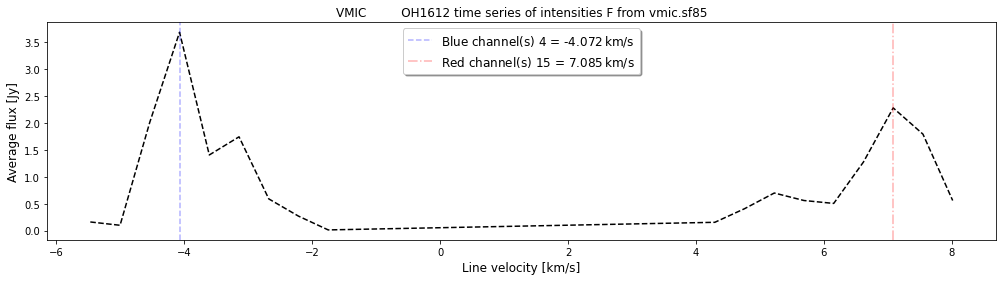

In [48]:
fig_name = f'{sources}_avg_spectrum.png'
plot_spectra(chan_vel, avg_spectra, blue_ch_idx, red_ch_idx, fig_name=fig_name)

## Time series plot

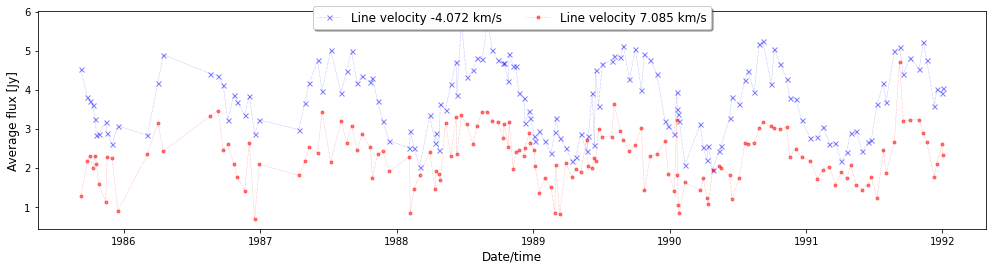

In [49]:
blue_spectrum = spectra[:, blue_ch_idx].mean(axis=1)
red_spectrum = spectra[:, red_ch_idx].mean(axis=1)
jd_datetime = ts_jd.datetime

fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 4),
                       facecolor='white')
ax.plot(jd_datetime, blue_spectrum,
        color='b', marker='x', linestyle=':', linewidth=0.5, markersize=5,
        label = 'Line velocity {} km/s'.format(chan_vel[max_blue_idx]),
        alpha=0.5)
ax.plot(jd_datetime, red_spectrum,
        color='r', marker='.', linestyle=':', linewidth=0.5, markersize=6,
        label = 'Line velocity {} km/s'.format(chan_vel[max_red_idx]),
        alpha=0.5)

ax.set_xlabel('Date/time', fontsize=12)
ax.set_ylabel('Average flux [Jy]', fontsize=12)

ax.legend(ncol=2,
          loc='upper center',
          bbox_to_anchor=(0.5, 1.05),
          numpoints=1,
          fancybox=True,
          shadow=True,
          fontsize=12)

plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)

fig_name = f'{sources}_ts_blue{max_blue_ch}_red{max_red_ch}.png'
plt.savefig(fig_name,
            bbox_inches='tight')

plt.show()

## Write channels to file

In [50]:
outfile = f'{sources}_ts_blue{max_blue_ch}_red{max_red_ch}.tscat'
[comment, head_line] = header.strip().split('\n')
comment ='{}\n'.format(comment.strip())
comment += '{}, {:.3f}, {:.3f}\n'.format(head_line.split(',')[0], chan_vel[max_blue_idx], chan_vel[max_red_idx])

show_spectra = np.vstack([blue_spectrum, red_spectrum]).T
io.output(outfile, comment, timestamps, show_spectra)

# 3D plots for presentations

In [51]:
(x, y) = np.meshgrid(np.asarray(timestamps, dtype=float), chan_vel)
z = spectra.T

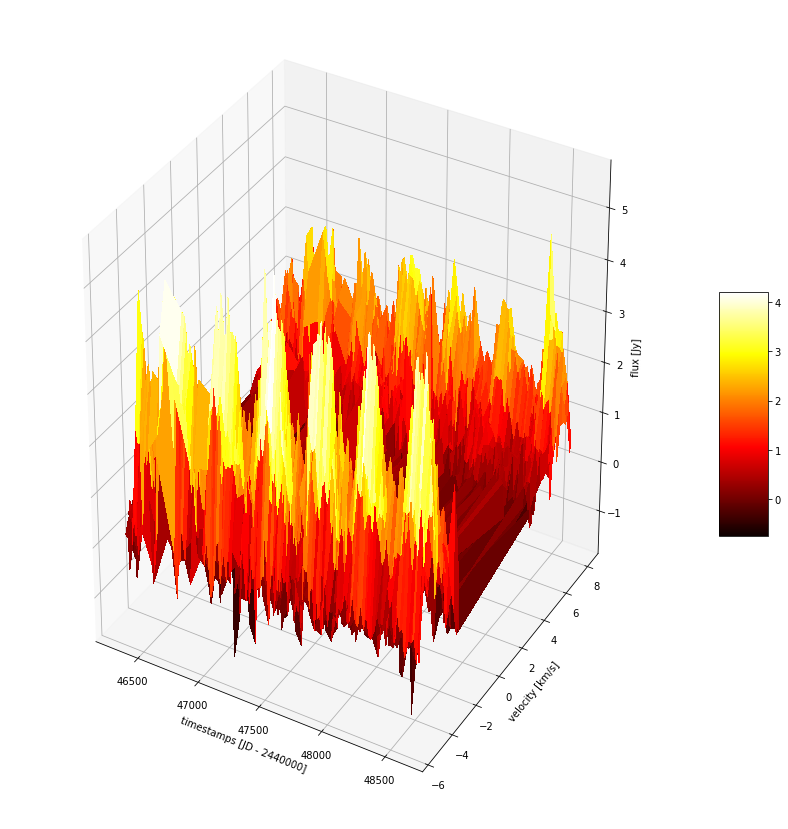

In [52]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15, 15), facecolor='white')
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x,y,z, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.3, aspect=5)
ax.set_xlabel('timestamps [JD - 2440000]')
ax.set_ylabel('velocity [km/s]')
ax.set_zlabel('flux [Jy]')
plt.show()

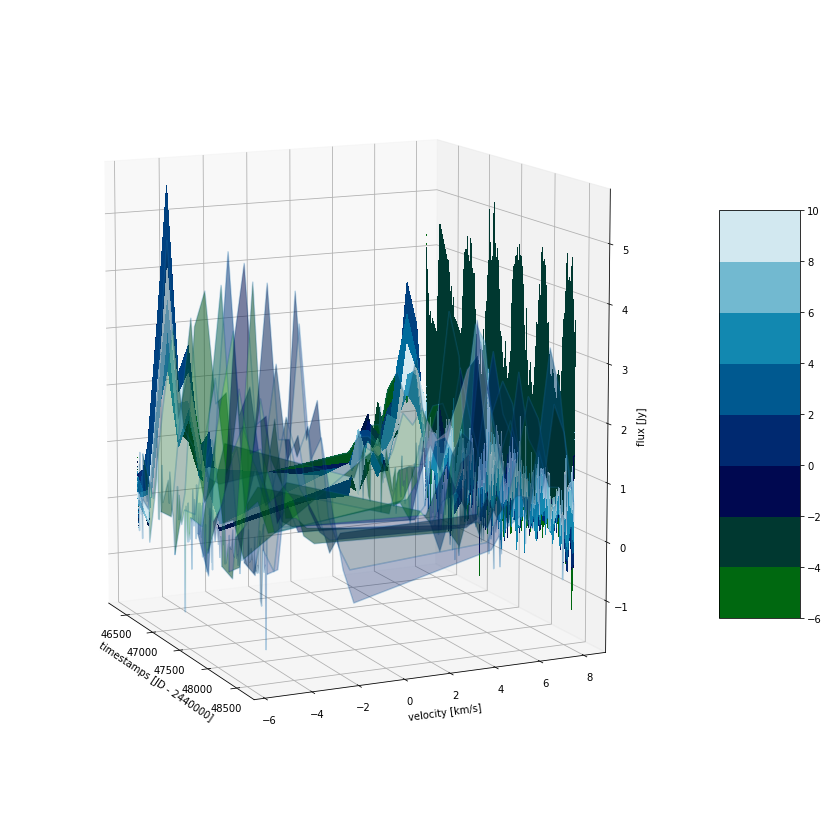

In [53]:
from matplotlib import cm
fig = plt.figure(figsize=(15, 15), facecolor='white')
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, rstride=10, cstride=10, cmap=cm.ocean, alpha=0.3)
ax.plot_surface(x, y, z, rstride=10, cstride=10, cmap=cm.ocean, alpha=0.3)
cset = ax.contourf(x, y, z, zdir='x', offset=np.min(x), cmap=cm.ocean)
cset = ax.contourf(x, y, z, zdir='y', offset=np.max(y), cmap=cm.ocean)
fig.colorbar(cset, ax=ax, shrink=0.5, aspect=5)
ax.view_init(10, -25)
ax.set_xlabel('timestamps [JD - 2440000]')
ax.set_ylabel('velocity [km/s]')
ax.set_zlabel('flux [Jy]')
plt.show()

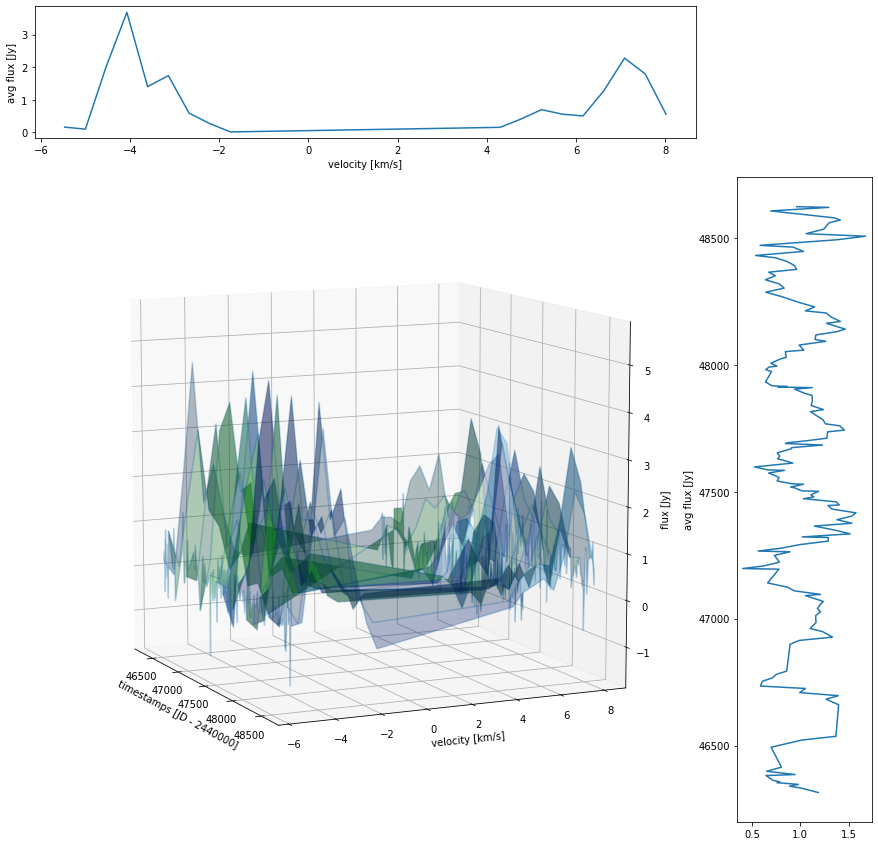

In [54]:
from matplotlib import gridspec
fig= plt.subplots(figsize=(15,15), facecolor='white')
gs = gridspec.GridSpec(5, 5, hspace=0.3, wspace=0.3)
ax0 = plt.subplot(gs[0, :-1])
ax0.plot(chan_vel, spectra.mean(axis=0))
ax0.set_xlabel('velocity [km/s]')
ax0.set_ylabel('avg flux [Jy]')

ax1 = plt.subplot(gs[1:, :-1], projection='3d')
ax1.plot_wireframe(x, y, z, rstride=10, cstride=10, cmap=cm.ocean, alpha=0.3)
ax1.plot_surface(x, y, z, rstride=10, cstride=10, cmap=cm.ocean, alpha=0.3)
ax1.view_init(10, -25)
ax1.set_xlabel('timestamps [JD - 2440000]')
ax1.set_ylabel('velocity [km/s]')
ax1.set_zlabel('flux [Jy]')

ax2 = plt.subplot(gs[1:, -1])
ax2.plot(spectra.mean(axis=1), timestamps)
ax2.set_ylabel('timestamps [JD - 2440000]')
ax2.set_ylabel('avg flux [Jy]')
plt.show()